<a href="https://colab.research.google.com/github/earo12/Payments_Fraud_Detection/blob/main/Online_Payments_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Online Payments Fraud Detection
## Columns have the next nonmenclature:

1)step: represents a unit of time where 1 step equals 1 hour

2)type: type of online transaction

3)amount: the amount of the transaction

4)nameOrig: customer starting the transaction

5)oldbalanceOrg: balance before the transaction

6)newbalanceOrig: balance after the transaction

7)nameDest: recipient of the transaction

8)oldbalanceDest: initial balance of recipient before the 
transaction

9)newbalanceDest: the new balance of recipient after the transaction

10)isFraud: fraud transaction

I'll be using two algorithms to solve this project. Because it is a classification problem, here I'm using Decision Tree Algorithm as well as Random Forest Algorithm

## Loading libraries

In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multioutput import MultiOutputRegressor

In [108]:
df = pd.read_csv('PS.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


### Statistical information

In [110]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    1
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64

Here whe can see we have some null values at the data frame, after I checked all of them I found that every NaN value was followed by a zero, so I'll fill them with a zero as well

In [111]:
df['oldbalanceDest'].fillna(0,inplace = True)

In [112]:
df['newbalanceDest'].fillna(0,inplace = True)
df['isFraud'].fillna(0, inplace = True)
df['isFlaggedFraud'].fillna(0, inplace = True)

Let's take a look into each attribute of the DataFrame

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1832400 entries, 0 to 1832399
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         float64
 10  isFlaggedFraud  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 153.8+ MB


From here we can see there are three attributes wich are not specifically numbers, let's take a look deeper in them

In [114]:
df['type'].value_counts()

CASH_OUT    657124
PAYMENT     608174
CASH_IN     403134
TRANSFER    151974
DEBIT        11994
Name: type, dtype: int64

In [115]:
df['oldbalanceDest'].value_counts()

0.00          762252
125.00            18
198.00            16
102.00            16
214.00            15
               ...  
2720268.79         1
2168634.28         1
116389.43          1
2328247.91         1
792609.66          1
Name: oldbalanceDest, Length: 1058782, dtype: int64

In [116]:
df['newbalanceDest'].value_counts()

0.00           698832
971418.91          32
19169204.93        29
16532032.16        25
1254956.07         25
                ...  
476356.97           1
1046193.33          1
550478.65           1
6344393.04          1
845840.32           1
Name: newbalanceDest, Length: 888791, dtype: int64

### Plots

As we see, we only have five rows from the attribute type, let's check them as a plot and see if we can find something interesting

In [117]:
values_df = df['type'].value_counts()

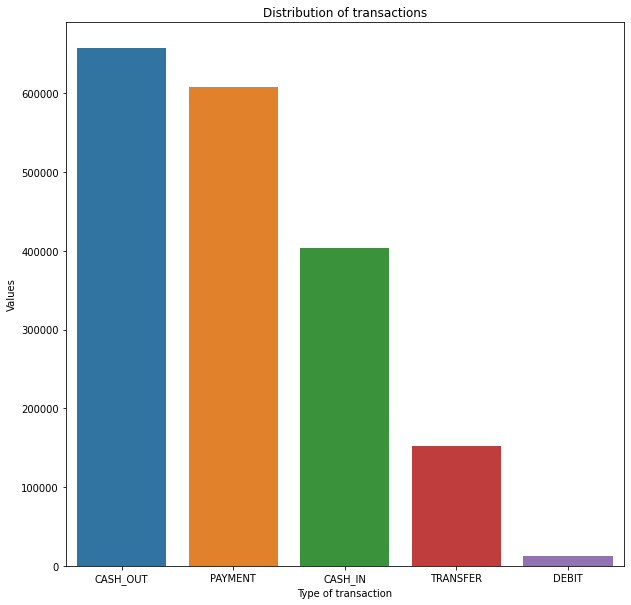

In [118]:
sns.barplot(data = df, x = values_df.index, y = values_df.values)
plt.xlabel('Type of transaction')
plt.ylabel('Values')
plt.title('Distribution of transactions')
plt.show()

From here, we can see many of the data it's with PAYMENT as a type of transaction, so let's check now whether there is a correlation from each attribute in the DataFrame that can tell us something related with isFraud field.

To do that, we can us the corr method in the DataFrame.

In [119]:
df.corr()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.009920,-0.007915,-0.007319,0.009479,-0.000532,0.001716,NaN
amount,0.009920,1.000000,0.001059,-0.004594,0.214391,0.310118,0.133419,NaN
oldbalanceOrg,-0.007915,0.001059,1.000000,0.999013,0.092490,0.063033,0.005253,NaN
newbalanceOrig,-0.007319,-0.004594,0.999013,1.000000,0.094461,0.062757,-0.008811,NaN
oldbalanceDest,0.009479,0.214391,0.092490,0.094461,1.000000,0.983272,-0.006958,NaN
newbalanceDest,-0.000532,0.310118,0.063033,0.062757,0.983272,1.000000,0.000476,NaN
isFraud,0.001716,0.133419,0.005253,-0.008811,-0.006958,0.000476,1.000000,NaN
isFlaggedFraud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's view the last shell in a heat map 

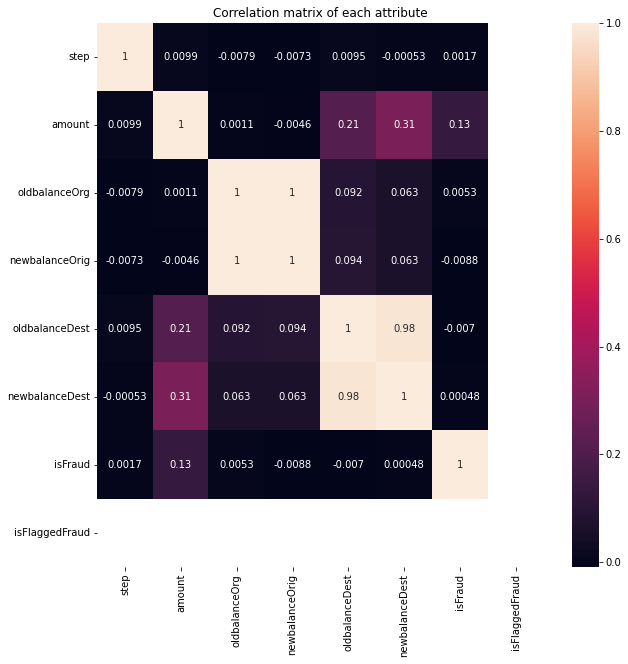

In [120]:
plt.rcParams['figure.figsize'] = (10,10)
sns.heatmap(data = df.corr(), annot = True)
plt.title('Correlation matrix of each attribute')
plt.show()

Now we can transform some data into numeric with scikit-learn

In [121]:
df['type']

0           PAYMENT
1           PAYMENT
2          TRANSFER
3          CASH_OUT
4           PAYMENT
             ...   
1832395    CASH_OUT
1832396    CASH_OUT
1832397    CASH_OUT
1832398    CASH_OUT
1832399    CASH_OUT
Name: type, Length: 1832400, dtype: object

I'll be using Label Encoder as a part of scikit-learn library

In [122]:
encoder = LabelEncoder()
df['type'] = encoder.fit_transform(df['type'])

In [123]:
df['isFraud'] = df['isFraud'].map({0 :'Not Fruad', 1 : 'Fraud'})
df['isFraud']

0          Not Fruad
1          Not Fruad
2              Fraud
3              Fraud
4          Not Fruad
             ...    
1832395    Not Fruad
1832396    Not Fruad
1832397    Not Fruad
1832398    Not Fruad
1832399    Not Fruad
Name: isFraud, Length: 1832400, dtype: object

In [124]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,Not Fruad,0.0
1,1,3,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,Not Fruad,0.0
2,1,4,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,Fraud,0.0
3,1,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,Fraud,0.0
4,1,3,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,Not Fruad,0.0


### Training models and predictions

Now we can check with train test split 

In [171]:
X = np.array(df[["type", "amount", "oldbalanceOrg", "newbalanceOrig"]])
y = np.array(df[["isFraud"]])
X_train , X_test , y_train , y_test = train_test_split(x,y,test_size = 0.33,random_state = 42)


In [172]:
X_train

array([[3.0000000e+00, 2.6844320e+04, 1.9564000e+04, 0.0000000e+00],
       [1.0000000e+00, 2.5323266e+05, 1.0700000e+02, 0.0000000e+00],
       [3.0000000e+00, 1.6294910e+04, 1.7929239e+05, 1.6299748e+05],
       ...,
       [1.0000000e+00, 2.4626118e+05, 2.4818000e+04, 0.0000000e+00],
       [1.0000000e+00, 5.1296659e+05, 2.0230000e+04, 0.0000000e+00],
       [3.0000000e+00, 1.0055710e+04, 0.0000000e+00, 0.0000000e+00]])

In [174]:
dt = DecisionTreeClassifier()
ft = dt.fit(X_train, y_train)
print(ft.score(X_test, y_test))

0.9995038796610506


In [176]:
clf = RandomForestClassifier(n_estimators = 100)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

<ipython-input-176-4490a27af0a7>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


0.9995766439774298


In [181]:
y_pred_dt = dt.predict(X_test)
y_pred_clf = clf.predict(X_test)

In [182]:
print(f'Accuracy with Decision Tree Classifier:{metrics.accuracy_score(y_test,y_pred_dt)}')
print(f'Accuracy with Random Forest Classifier:{metrics.accuracy_score(y_test,y_pred_clf)}')

Accuracy with Decision Tree Classifier:0.9995038796610506
Accuracy with Random Forest Classifier:0.9995766439774298


So far we can see both models work with a high accuracy, let's make some predictions with unseen labels 

In [185]:
new_labels = np.array([[2,4231.04, 3123.01, 130.00]])
print(f'Prediction with Decision Tree Classifier : {dt.predict(new_labels)}')
print(f'Prediciton with Random Forest Classifier : {clf.predict(new_labels)}')

Prediction with Decision Tree Classifier : ['Not Fruad']
Prediciton with Random Forest Classifier : ['Not Fruad']


### Validation of models

Now we can check our model with the confusion matrix

In [187]:
matrix_dt = confusion_matrix(y_test, y_pred_dt)
matrix_clf = confusion_matrix(y_test, y_pred_clf)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


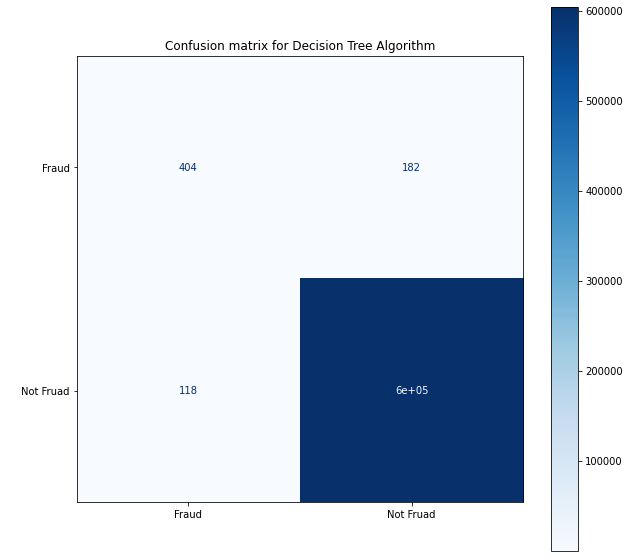

In [191]:
color = 'white'
plot_confusion_matrix(dt, X_test, y_test, cmap = plt.cm.Blues)
plt.xlabel('Predicted label', color = color)
plt.ylabel('True label', color = color)
plt.title('Confusion matrix for Decision Tree Algorithm')
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


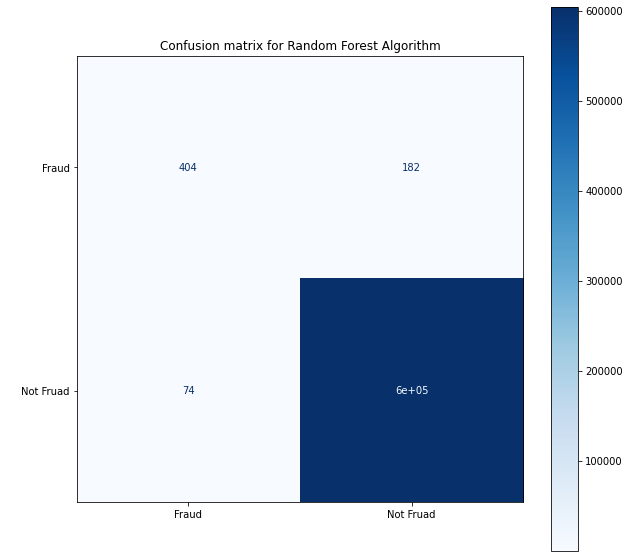

In [192]:
color = 'white'
plot_confusion_matrix(clf, X_test, y_test, cmap = plt.cm.Blues)
plt.xlabel('Predicted label', color = color)
plt.ylabel('True label', color = color)
plt.title('Confusion matrix for Random Forest Algorithm')
plt.show()

We can check the classification report

In [194]:
print(f'Classification report for Decision Tree: {classification_report(y_test, y_pred_dt)}')

Classification report for Decision Tree:               precision    recall  f1-score   support

       Fraud       0.77      0.69      0.73       586
   Not Fruad       1.00      1.00      1.00    604106

    accuracy                           1.00    604692
   macro avg       0.89      0.84      0.86    604692
weighted avg       1.00      1.00      1.00    604692



In [195]:
print(f'Classification report for Random Forest: {classification_report(y_test, y_pred_clf)}')

Classification report for Random Forest:               precision    recall  f1-score   support

       Fraud       0.85      0.69      0.76       586
   Not Fruad       1.00      1.00      1.00    604106

    accuracy                           1.00    604692
   macro avg       0.92      0.84      0.88    604692
weighted avg       1.00      1.00      1.00    604692



Finally we can check the ROC curve in order to prove our model

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'ROC curve for Decision Tree Algorithm')

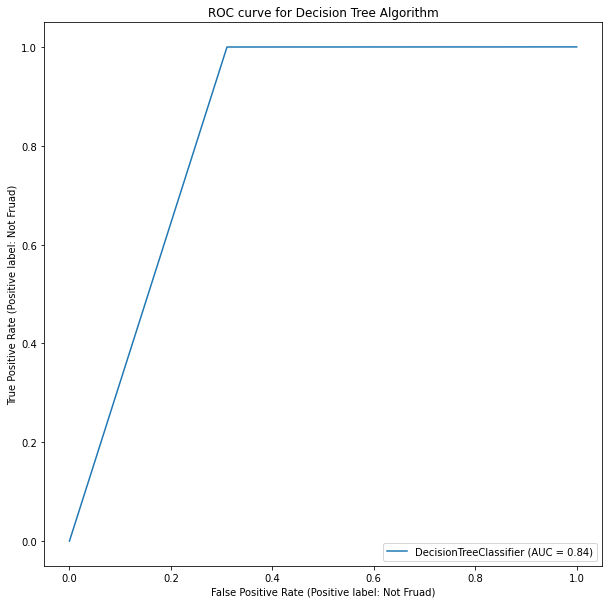

In [199]:
plot_roc_curve(dt, X_test, y_test)
plt.title('ROC curve for Decision Tree Algorithm')

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


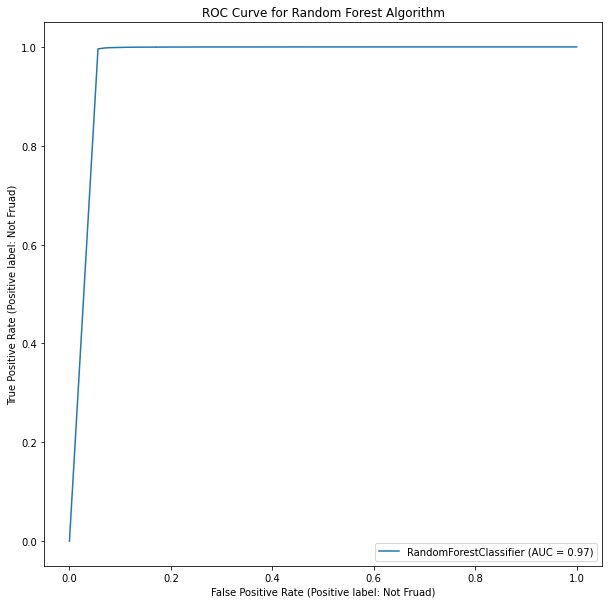

In [200]:
plot_roc_curve(clf, X_test, y_test)
plt.title('ROC Curve for Random Forest Algorithm')
plt.show()

As a conclussion, we can see that decision tree algorithm was better because it has lower accuracy, also we can find up random forest classifier may be overfitting, in order to avoid it we should choose more stimators by taking the disadvantage of more computer power as well.